In [1]:
from sklearnex import patch_sklearn 

patch_sklearn()

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import sys
sys.path.insert(0,'..')
import module as mod


from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import fbeta_score, accuracy_score
from sklearn.semi_supervised import SelfTrainingClassifier

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


# 1. Import et nettoyage des données

In [2]:
house1_power_blk2 = mod.load_dataset('house1_power_blk2_labels.zip')
house1_power_blk2.head()

,mains,activity,hour
datetime,,,
2016-03-06 00:00:00,473.0,0,0.0
2016-03-06 00:00:01,474.0,0,0.0
2016-03-06 00:00:02,476.0,0,0.0
2016-03-06 00:00:03,476.0,0,0.0
2016-03-06 00:00:04,475.0,0,0.0


In [3]:
house2_power_blk1 = mod.load_dataset('house2_power_blk1_labels.zip')
house2_power_blk1.head()

,mains,activity,hour
datetime,,,
2017-09-12 23:00:00,103.0,0,23.0
2017-09-12 23:00:01,101.0,0,23.0
2017-09-12 23:00:02,104.0,0,23.0
2017-09-12 23:00:03,104.0,0,23.0
2017-09-12 23:00:04,105.0,0,23.0


In [4]:
windows = ['1h', '10min']
features_col = ['mains', 'hour']

house1_power_blk2, _ = mod.generate_features(house1_power_blk2, window=windows)
house2_power_blk1, cols = mod.generate_features(house2_power_blk1, window=windows)
features_col += cols

# 3. Algorithmes généraux : house 2 vs house 1
## 3.1 Scaler fitté sur la maison 2

Score f_beta : 79.569%
Score accuracy : 78.636%


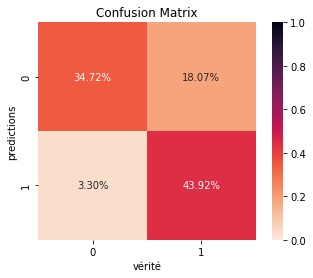

In [5]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(house2_power_blk1[features_col].values)
scaler.fit(house1_power_blk2.iloc[:24*60*60*15,:].loc[:, features_col].values)
X_test = scaler.transform(house1_power_blk2.iloc[24*60*60*15:,:].loc[:, features_col].values)

y_train = house2_power_blk1['activity'].values
y_test = house1_power_blk2.iloc[24*60*60*15:,:].loc[:, 'activity'].values

classifier = RandomForestClassifier(n_estimators=30, n_jobs=-1, max_samples=0.9, max_depth=12)
classifier.fit(X_train, y_train.ravel())
y_pred = classifier.predict(X_test)
y_pred_smooth = (pd.Series(y_pred).rolling(10*60).mean()>0).astype(int).values

mod.plot_confusion_matrix(y_test, y_pred);

Score f_beta : 75.011%
Score accuracy : 72.956%


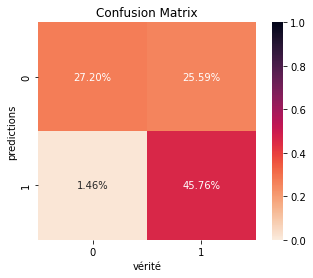

In [6]:
# on teste la performance avc la courbe lissée
mod.plot_confusion_matrix(y_test, y_pred_smooth);

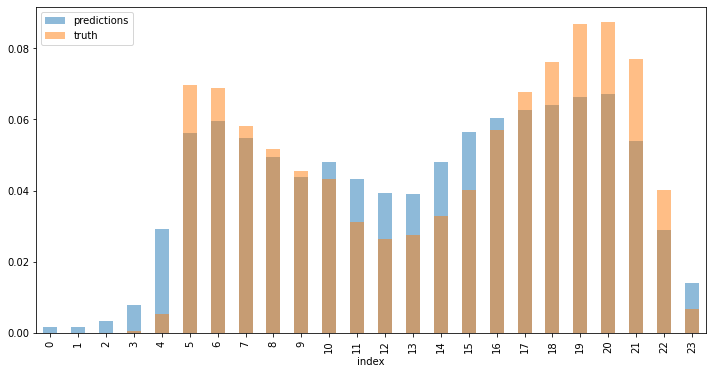

In [7]:
house1_power_blk2_res = house1_power_blk2.copy()
house1_power_blk2_res['activity_pred'] = np.nan
house1_power_blk2_res.iloc[24*60*60*15:, -1] = (y_pred > 0.5).astype(int)
house1_power_blk2_res.iloc[24*60*60*15:].head()

fig, ax = plt.subplots()
mod.plot_activity_hist(house1_power_blk2_res['activity_pred'].iloc[24*60*60*15:], figsize=(12, 6), alpha=0.5, label='predictions', ax=ax)
mod.plot_activity_hist(house1_power_blk2['activity'].iloc[24*60*60*15:], figsize=(12, 6), alpha=0.5, label='truth', color='tab:orange', ax=ax)

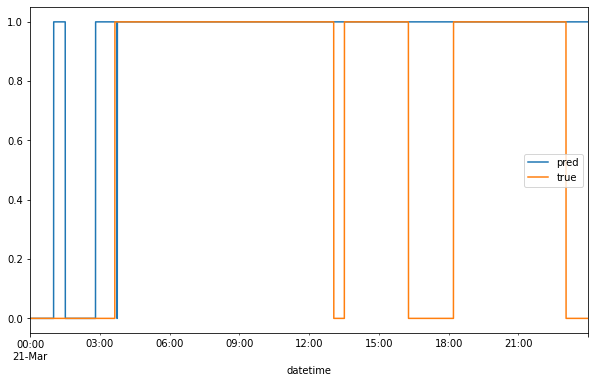

In [8]:
start_window = 24*60*60*15
activity_pred = (house1_power_blk2_res['activity_pred'].iloc[start_window:start_window+60*60*24].rolling('30min').mean()>0).astype(int)
activity_true = (house1_power_blk2['activity'].iloc[start_window:start_window+60*60*24].rolling('30min').mean()>0).astype(int)
activity_pred.plot(figsize=(10, 6), label='pred', legend=True)
activity_true.plot(label='true', legend=True);

In [29]:
# activity_pred.plot(figsize=(10, 6))
# activity_pred.diff(1).plot(figsize=(10, 6))

def activity_periods(data_activity):
    """
    Extracts the activity time periods
    Args:
       data_activity: the time series from which we want to extract the activity time periods
    returns: a pandas series with a line for each activity time period as a pandas Intervalle
    """
    data_activity.iloc[-1] = 0
    data_activity.iloc[-1] = 0
    
           # on définit un nouveau dataframe avec diff = 1 si début d'activité, -1 si fin
    return pd.DataFrame(data_activity.diff(1)[data_activity.diff(1)!=0].dropna().replace(-1, 'end').replace(1, 'begin')) \
           .reset_index().set_axis(['datetime', 'activity'], axis=1, inplace=False)\
           .pivot(values='datetime', columns='activity').fillna(method='ffill').iloc[1::2, :].reset_index(drop=True).apply(lambda x: pd.Interval(x['begin'], x['end'], closed='neither'), axis=1) # on fait un pivot, ffil et on supprime une ligne sur deux
act_per_pred = activity_periods(activity_pred)

In [17]:
act_per_true = activity_periods(activity_true)
act_per_true

0    (2016-03-21 03:38:39, 2016-03-21 13:03:32)
1    (2016-03-21 13:31:01, 2016-03-21 16:16:19)
2    (2016-03-21 18:12:33, 2016-03-21 23:02:57)
dtype: interval

In [18]:
def detect_overlaps(data_act_true, data_act_pred):
    """
    Defines for each line of data_act_true how many lines of data_act_pred it overlaps
    Args:
        data_act_true: true activity periods
        data_act_pred: predicted activity periods
    return: A pandas series with the for each data_act_true period how many pperiod of data_act_pred they overlap
    """
    return data_act_true.apply(lambda x: np.array([x.overlaps(data_act_pred.iloc[i]) for i in range(data_act_pred.shape[0])]).sum())

detect_overlaps(act_per_true, act_per_pred)

0    2
1    1
2    1
dtype: int64

In [19]:
detect_overlaps(act_per_pred, act_per_true)

0    0
1    1
2    3
dtype: int64

In [30]:
def score_overlap(activity_true, activity_pred, resample_period='30min'):
    """
    Determines the number of activity periods that are detected (TP) and the number of activity periods detected when there was no true activity (FP)
    Args:
        activity_true: time series that contains the true activity labels
        activity_pred: time series that contains the predicted activity labels
        resample_period (optional): the time period to use to resample both time series
    returns: the percentage of true activity periods that are detected (TP) and the percentage of activity periods predicted when there was no true activity (FP)
    """

    # we start by smoothing the data
    activity_true = (activity_true.rolling(resample_period).mean()>0).astype(int).copy()
    activity_pred = (activity_pred.rolling(resample_period).mean()>0).astype(int).copy()

    # we get the activity perdiods for each activity series
    activity_per_true = activity_periods(activity_true)
    activity_per_pred = activity_periods(activity_pred)

    # we get the count of true activity periods
    T = activity_per_true.shape[0]
    F = activity_per_true.shape[0]

    # we estimate the true positives and false positives
    TP = (detect_overlaps(activity_per_true, activity_per_pred) > 0).sum()
    FP = (detect_overlaps(activity_per_pred, activity_per_true) == 0).sum()

    return TP/T, FP/F

TPR, FPR = score_overlap(house1_power_blk2['activity'], house1_power_blk2_res['activity_pred'])

print(f"true positive rate: {TPR:.2%}, false positive rate: {FPR:.2%}")

true positive rate: 75.51%, false positive rate: 51.02%


On peut en faire de même avec la maison 1 vs 2

Score f_beta : 83.218%
Score accuracy : 83.432%


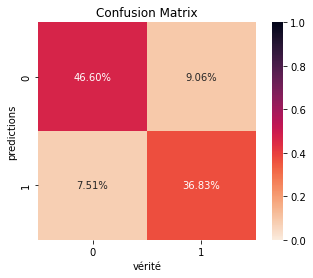

In [7]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(house1_power_blk2[features_col].values)
scaler.fit(house2_power_blk1.iloc[:24*60*60*15,:].loc[:, features_col].values)
X_test = scaler.transform(house2_power_blk1.iloc[24*60*60*15:,:].loc[:, features_col].values)

y_train = house1_power_blk2['activity'].values
y_test = house2_power_blk1.iloc[24*60*60*15:,:].loc[:, 'activity'].values

classifier = RandomForestClassifier(n_estimators=30, n_jobs=-1, max_samples=0.9, max_depth=12)
classifier.fit(X_train, y_train.ravel())
y_pred = classifier.predict(X_test)

mod.plot_confusion_matrix(y_test, y_pred);

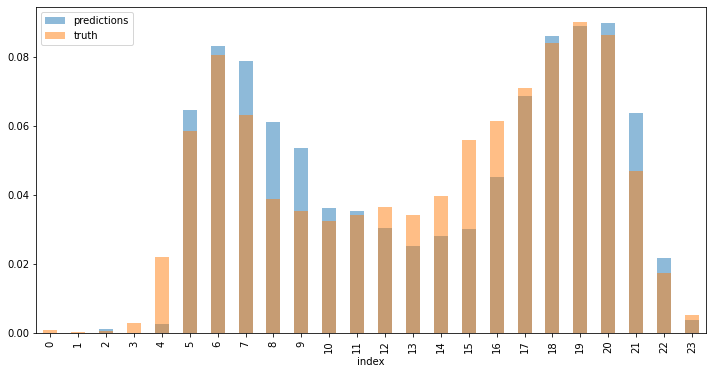

In [12]:
house2_power_blk1_res = house2_power_blk1.copy()
house2_power_blk1_res.loc[:, 'activity_pred'] = np.nan
house2_power_blk1_res.iloc[24*60*60*15:, -1] = (y_pred > 0.5).astype(int)
house2_power_blk1_res.iloc[24*60*60*15:].head()

fig, ax = plt.subplots()
mod.plot_activity_hist(house2_power_blk1_res['activity_pred'], figsize=(12, 6), alpha=0.5, label='predictions', ax=ax)
mod.plot_activity_hist(house2_power_blk1['activity'].iloc[24*60*60*15:], figsize=(12, 6), alpha=0.5, label='truth', color='tab:orange', ax=ax)

# 3.3 Fitting scaler + re-fitting du modèle
L'idée est cette fois de fitter le scaler sur une partie de la maison 1 (test) mais aussi de re-fitter le modèle avec une partie des données test.

In [8]:
def classif_scale_fit_window(data_train, data_test, window=1, scaler=MinMaxScaler()):
    
    classifier=RandomForestClassifier(n_estimators=30, n_jobs=-1, max_samples=0.9, max_depth=12, warm_start=True)
    X_train = scaler.fit_transform(data_train[features_col].values)
    # Attention : ici on re-fit le scaler sur les données du test
    X_test_known = scaler.fit_transform(data_test.iloc[:24*60*60*window,:].loc[:, features_col].values)
    X_test = scaler.transform(data_test.iloc[24*60*60*window:,:].loc[:, features_col].values)

    y_train = data_train['activity'].values
    y_test_known = data_test.iloc[:24*60*60*window,:].loc[:, 'activity'].values
    y_test = data_test.iloc[24*60*60*window:,:].loc[:, 'activity'].values

    classifier.fit(X_train, y_train.ravel())
    classifier.n_estimators += 30
    classifier.fit(X_test_known, y_test_known.ravel())
    y_pred = classifier.predict(X_test)

    f_beta = fbeta_score(y_test, y_pred, average="macro", beta=0.5)
    acc = accuracy_score(y_test, y_pred)

    return f_beta, acc

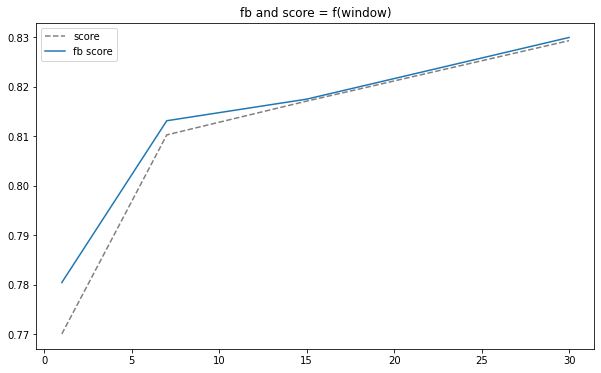

In [24]:
w_range = [1, 7, 15, 30]
fb_score = []
acc_score = []
for w in w_range:
    fb, acc = classif_scale_fit_window(house2_power_blk1, house1_power_blk2, window=w)
    fb_score.append(fb)
    acc_score.append(acc)

plt.figure(figsize=(10, 6));
plt.plot(w_range, acc_score, label='score', color='grey', linestyle='dashed');
plt.plot(w_range, fb_score, label='fb score');
plt.legend();
plt.title('fb and score = f(window)');

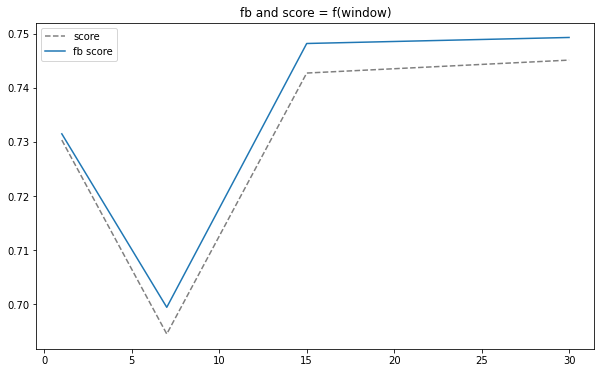

In [25]:
w_range = [1, 7, 15, 30]
fb_score = []
acc_score = []
for w in w_range:
    fb, acc = classif_scale_fit_window(house2_power_blk1, house1_power_blk2, window=w, scaler=StandardScaler())
    fb_score.append(fb)
    acc_score.append(acc)

plt.figure(figsize=(10, 6));
plt.plot(w_range, acc_score, label='score', color='grey', linestyle='dashed');
plt.plot(w_range, fb_score, label='fb score');
plt.legend();
plt.title('fb and score = f(window)');

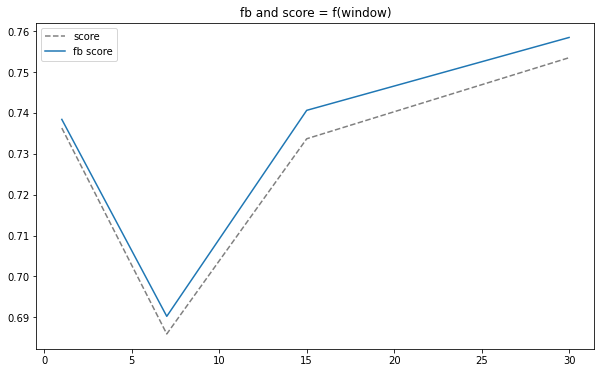

In [9]:
w_range = [1, 7, 15, 30]
fb_score = []
acc_score = []
for w in w_range:
    fb, acc = classif_scale_fit_window(house2_power_blk1, house1_power_blk2, window=w, scaler=QuantileTransformer())
    fb_score.append(fb)
    acc_score.append(acc)

plt.figure(figsize=(10, 6));
plt.plot(w_range, acc_score, label='score', color='grey', linestyle='dashed');
plt.plot(w_range, fb_score, label='fb score');
plt.legend();
plt.title('fb and score = f(window)');

Cette méthode nécessite néanmoins d'avoir accès à une partie des données test labelisées. Une façon de contourner cela serait de considérer les périodes de nuit comme inactives et celles de jour comme actives mais cela représente une grosse approximation.

# 4. Self-training

In [8]:
def classif_self_training_window(data_train, data_test, window=1, scaler=MinMaxScaler()):
    
    classifier= SelfTrainingClassifier(RandomForestClassifier(n_estimators=30, n_jobs=-1, max_samples=0.9, max_depth=12))
    X_train = scaler.fit_transform(data_train[features_col].values)
    # Attention : ici on re-fit le scaler sur les données du test
    X_test_known = scaler.fit_transform(data_test.iloc[:24*60*60*window,:].loc[:, features_col].values)
    X_test_unknown = scaler.transform(data_test.iloc[24*60*60*window:,:].loc[:, features_col].values)
    X = np.concatenate((X_train, X_test_known), axis=0)

    y_train = data_train['activity'].values
    y_test_known = np.ones((data_test.iloc[:24*60*60*window,:].loc[:, 'activity'].values .shape[0],)) * -1
    y_test_unknown = data_test.iloc[24*60*60*window:,:].loc[:, 'activity'].values 

    y = np.concatenate((y_train, y_test_known), axis=0)

    classifier.fit(X, y.ravel())
    y_pred = classifier.predict(X_test_unknown)

    f_beta = fbeta_score(y_test_unknown, y_pred, average="macro", beta=0.5)
    acc = accuracy_score(y_test_unknown, y_pred)

    return f_beta, acc

done with w=1
done with w=7
done with w=15
done with w=30
done with w=40


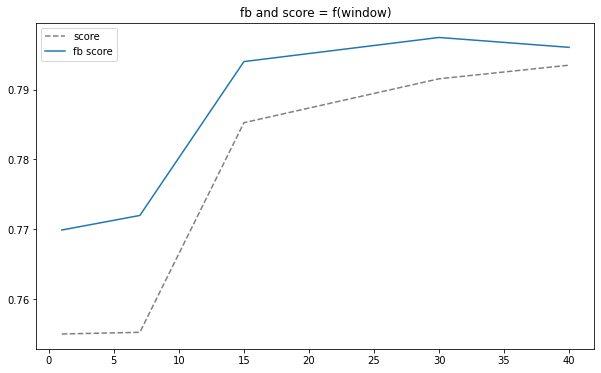

In [9]:
w_range = [1, 7, 15, 30, 40]
fb_score = []
acc_score = []
for w in w_range:
    fb, acc = classif_self_training_window(house2_power_blk1, house1_power_blk2, window=w)
    fb_score.append(fb)
    acc_score.append(acc)
    print(f'done with w={w}')

plt.figure(figsize=(10, 6));
plt.plot(w_range, acc_score, label='score', color='grey', linestyle='dashed');
plt.plot(w_range, fb_score, label='fb score');
plt.legend();
plt.title('fb and score = f(window)');


Score f_beta : 79.676%
Score accuracy : 79.157%


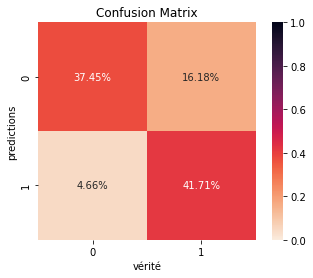

In [11]:
w = 30
scaler = MinMaxScaler()
classifier= SelfTrainingClassifier(RandomForestClassifier(n_estimators=30, n_jobs=-1, max_samples=0.9, max_depth=12))
X_train = scaler.fit_transform(house2_power_blk1[features_col].values)
# Attention : ici on re-fit le scaler sur les données du test
X_test_unlabelled = scaler.fit_transform(house1_power_blk2.iloc[:24*60*60*w,:].loc[:, features_col].values)
X_test_unknown = scaler.transform(house1_power_blk2.iloc[24*60*60*w:,:].loc[:, features_col].values)
X = np.concatenate((X_train, X_test_unlabelled), axis=0)

y_train = house2_power_blk1['activity'].values
y_test_unlabelled = np.ones((house1_power_blk2.iloc[:24*60*60*w,:].loc[:, 'activity'].values.shape[0],)) * -1
y_test_unknown = house1_power_blk2.iloc[24*60*60*w:,:].loc[:, 'activity'].values

y = np.concatenate((y_train, y_test_unlabelled), axis=0).astype(int)

classifier.fit(X, y.ravel())
y_pred = classifier.predict(X_test_unknown)

mod.plot_confusion_matrix(y_test_unknown, y_pred);

# 5. Semi-Supervised : S3VM

In [5]:
#! pip install semisupervised
import semisupervised as ssl

In [6]:
scaler = MinMaxScaler()
classifier= ssl.S3VM()
X_train = scaler.fit_transform(house2_power_blk1[features_col].values)
# Attention : ici on re-fit le scaler sur les données du test
X_test_unlabelled = scaler.fit_transform(house1_power_blk2.iloc[:24*60*60*30,:].loc[:, features_col].values)
X_test_unknown = scaler.transform(house1_power_blk2.iloc[24*60*60*30:,:].loc[:, features_col].values)
X = np.concatenate((X_train, X_test_unlabelled), axis=0)

y_train = house2_power_blk1['activity'].values
y_test_unlabelled = np.ones((house1_power_blk2.iloc[:24*60*60*30,:].loc[:, 'activity'].values.shape[0],)) * -1
y_test_unknown = house1_power_blk2.iloc[24*60*60*30:,:].loc[:, 'activity'].values

y = np.concatenate((y_train, y_test_unlabelled), axis=0).astype(int)

classifier.fit(X, y.ravel())
y_pred = classifier.predict(X_test_unknown)

mod.plot_confusion_matrix(y_test_unknown, y_pred);

/home/pierre/.local/lib/python3.8/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


Error: Canceled future for execute_request message before replies were done